### Bidirectional LSTM Tutorial

This is to implement Bidirectional LSTM module. 

Sometimes we want our model to learn not only with before information, but also we want our model to `learn later information` to do final decision, so here our model could `learn something longer than before` as we also consider something useful later. 

Suppose you want to predict the words in this sentence: "lu not only like to do machine _ , but he also like deep learning", for which word should be for the black? that should be `"learning"`, but if we just do forward step, we could just learn with: "lu not only like to do machine ", but if we use **bidirectional RNN**, we could also learn with: "but he also like deep learning", that's the key point for Bidirectional RNN, really powerful with more units and learn with later information!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import style
import os, shutil, tempfile

style.use('ggplot')

In [3]:
# we could check to use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
# hyper-paramters
sequence_size = 28
input_size = 28
hidden_units = 128
n_layers = 2
batch_size = 128
n_classes = 10
epochs = 5
learning_rate = .001

In [5]:
# we should load our training data with MNIST
train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                        transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                       transform=transforms.ToTensor(), download=True)
trainloader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data,
                                         batch_size=batch_size,
                                         shuffle=False)

In [6]:
# here we should define the model structure
class BiLSTMNet(nn.Module):
    def __init__(self):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_units, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_units * 2, n_classes)

    def forward(self, x):
        x = x.float()    # change the data type
        # we should first init model hidden states and cell states
        h0 = torch.zeros(n_layers * 2, x.size()[0], hidden_units).to(device)
        c0 = torch.zeros(n_layers * 2, x.size()[0], hidden_units).to(device)

        # we could just get model outputs with lstm
        # outs with batch_size * sequence_size * hidden_size * 2
        outs, _ = self.lstm(x, (h0, c0))
        # we just want to get the last unit's outputs result
        outs = self.fc(outs[:, -1, :])
        return outs

In [7]:
# we could initance our model, have to put the model also to GPU
model = BiLSTMNet().to(device)
print("Model structure: ", model)

Model structure:  BiLSTMNet(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
# we should instant our optimizer and loss object
# as this is multi-class problem, so the loss should be cross-entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
# store training loss and test accuracy
train_loss_list = []
test_acc_list = []

In [11]:
# start training, oohuu :)
for epoch in range(epochs):
    curr_loss = []
    for i, (images, labels) in enumerate(trainloader):
        # reshape our training images and put data to different device
        images = images.reshape(-1, sequence_size, input_size).to(device)
        labels = labels.to(device)

        # get train prediction
        pred_train = model(images)

        # get loss
        loss_train = criterion(pred_train, labels)

        # backward step and update model parameters
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if i % 100 == 0:
            print("{Epoch: %d}: Loss: %.2f" % (epoch, loss_train))

        curr_loss.append(loss_train)

    # store each epoch training loss
    train_loss_list.append(curr_loss)

    # after each epoch, we should evaluate our model with test data
    with torch.no_grad():
        total_size = len(testloader)
        correct_pred = 0
        for images, labels in testloader:
            images = images.reshape(-1, sequence_size, input_size).to(device)
            labels = labels.to(device)

            pred_test = model(images)
            _, preds = torch.max(pred_test, 1)
            total_size += labels.size()[0]
            correct_pred += (preds == labels).sum().item()
        test_acc_list.append((correct_pred / total_size) * 100)

{Epoch: 0}: Loss: 0.29
{Epoch: 0}: Loss: 0.31
{Epoch: 0}: Loss: 0.19
{Epoch: 0}: Loss: 0.13
{Epoch: 0}: Loss: 0.14
{Epoch: 1}: Loss: 0.09
{Epoch: 1}: Loss: 0.08
{Epoch: 1}: Loss: 0.10
{Epoch: 1}: Loss: 0.12
{Epoch: 1}: Loss: 0.13
{Epoch: 2}: Loss: 0.09
{Epoch: 2}: Loss: 0.04
{Epoch: 2}: Loss: 0.09
{Epoch: 2}: Loss: 0.02
{Epoch: 2}: Loss: 0.05
{Epoch: 3}: Loss: 0.12
{Epoch: 3}: Loss: 0.03
{Epoch: 3}: Loss: 0.06
{Epoch: 3}: Loss: 0.11
{Epoch: 3}: Loss: 0.10
{Epoch: 4}: Loss: 0.03
{Epoch: 4}: Loss: 0.06
{Epoch: 4}: Loss: 0.04
{Epoch: 4}: Loss: 0.06
{Epoch: 4}: Loss: 0.05


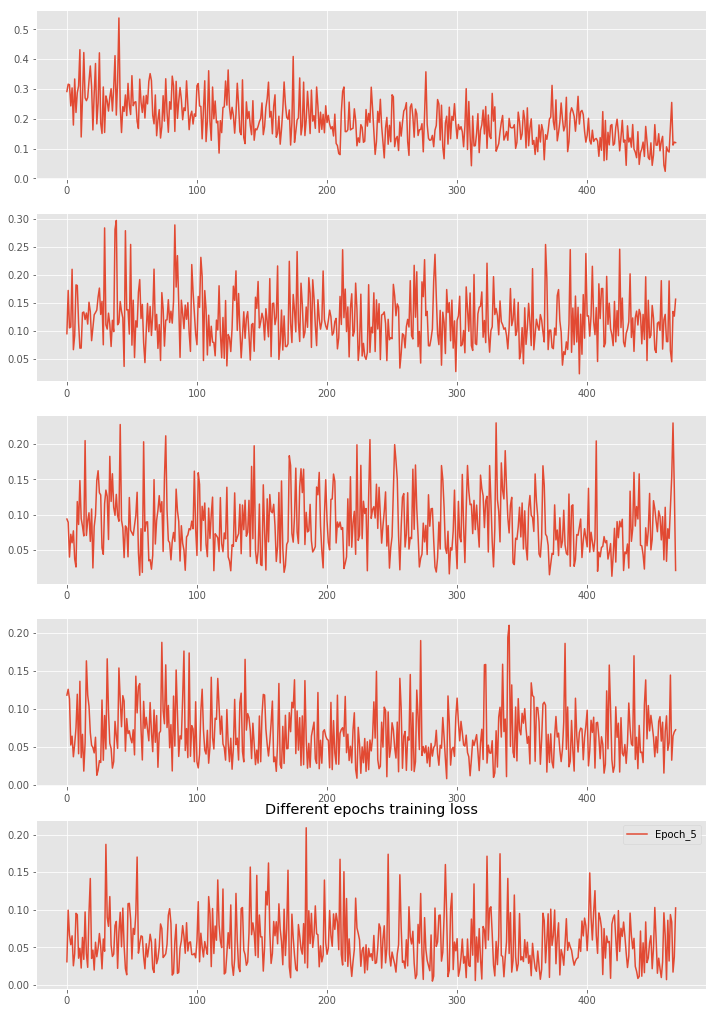

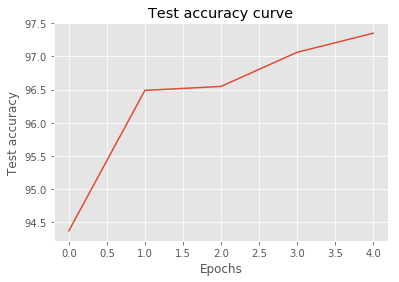

In [12]:
# Here I just wnat to plot 2 graphs, first is each epochs training loss curve
# the other is the test accuracy curve
fig, ax = plt.subplots(len(train_loss_list), 1, figsize=(12, 18))
for i in range(len(train_loss_list)):
    ax[i].plot(range(len(train_loss_list[i])), train_loss_list[i], label='Epoch_' + str(i + 1))
plt.title("Different epochs training loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.title("Test accuracy curve")
plt.xlabel("Epochs")
plt.ylabel("Test accuracy")
plt.grid(True)

plt.show()

In [13]:
# we could save our trained model checkpoint to disk, here I just save
# it to a temperate folder, you could just change the path you want
tmp_path = tempfile.mkdtemp()
torch.save(model.state_dict(), os.path.join(tmp_path, 'model.ckpt'))
print("Get model:", os.listdir(tmp_path))
# remove the temperate folder
shutil.rmtree(tmp_path)

Get model: ['model.ckpt']
